# Introduction

#### Airbnb Boston Data Anaylysis

In this notebook I look into Airbnb Boston Data to explore its business growth, prices, availability and ratings.

The data is obtained from Kaggle(https://www.kaggle.com/airbnb/boston) and it contain three data files:
1. calendar data: home availability data from September 2016 to September 2017.
2. listing data: home information data from January 2016 to January 2017 on 3,818 homes.
3. reviews data: house reviews between June 2009 and January 2016.

The question I try to answer in this notebook include:

1. What’s the home availability pattern?
2. What’s the business growth trend ?
3. How price and rating relate with each other?
4. What’s the major factor that influence price and ratings?

And the findings are presented also in this blog: https://medium.com/@haataa/interesting-facts-you-want-to-know-about-airbnb-boston-insight-behind-data-4c4bd4a40b74

In [9]:
# import packages
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap

%matplotlib inline

# Gather And Assess Data

In [90]:
# import data
bs_reviews = pd.read_csv("./data/boston_reviews.csv")
bs_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [119]:
bs_listing = pd.read_csv("./data/boston_listings.csv")
bs_listing.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.3


In [13]:
# have a closer look at listing data
bs_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

In [108]:
bs_calendar = pd.read_csv("./data/boston_calendar.csv")
bs_calendar.head()
bs_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
listing_id    1308890 non-null int64
date          1308890 non-null object
available     1308890 non-null object
price         643037 non-null object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


# Clean Data

In [109]:
# clean calendar data
## change column 'date' data type from 'object' to 'datetime'
to_datetime = lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d')
bs_calendar.date = bs_calendar.date.apply(to_datetime)
bs_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
listing_id    1308890 non-null int64
date          1308890 non-null datetime64[ns]
available     1308890 non-null object
price         643037 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 39.9+ MB


In [115]:
## remove '$' sign from price and change type to 'float'
def remove_dollar(x):
    if type(x) is str:
        x = float(x.replace('$','').replace(',',''))
    return x
#remove_dollar = lambda x: float(x.replace('$','').replace(',','')) if x.notnull()
bs_calendar.price = bs_calendar.price.apply(remove_dollar)
bs_calendar.info()

In [120]:
# clean listing data
## change column 'host_since' data type from 'str' to 'datetime'
bs_listing.host_since = bs_listing.host_since.apply(to_datetime)
## remove '$' sign from price
bs_listing.price = bs_listing.price.apply(remove_dollar)

# Availability and Prices

In [15]:
# total number of available home each day
avaliable_count_bs = bs_calendar.groupby('date').apply(lambda x: x.notnull().sum())[['price']]
# change column name
avaliable_count_bs = avaliable_count_bs.rename({"price":"total number of available houses"},axis='columns')

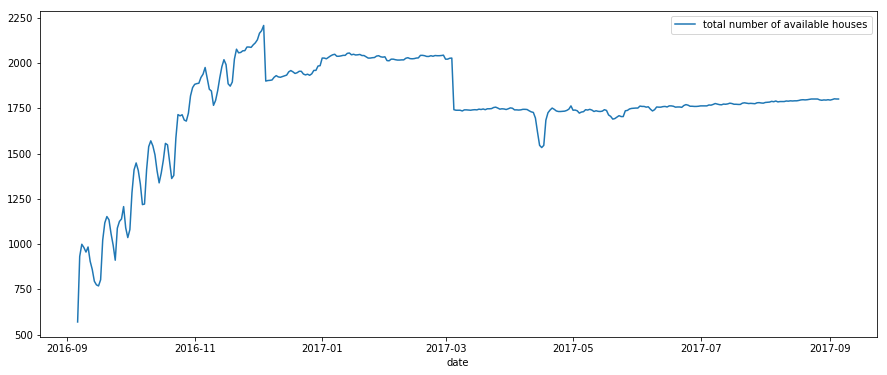

In [65]:
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=avaliable_count_bs)

In [17]:
# everyday average prices
bs_calendar_open = bs_calendar[bs_calendar.price.notnull()]
remove_dollar = lambda x: float(x.replace('$','').replace(',',''))
bs_calendar_open.price = bs_calendar_open.price.apply(remove_dollar)


/home/joopoo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [18]:
# average house price for boston everyday
average_price_bs = bs_calendar_open.groupby('date').mean()[['price']]
# change column name
average_price_bs = average_price_bs.rename({"price":"average prices"},axis='columns')

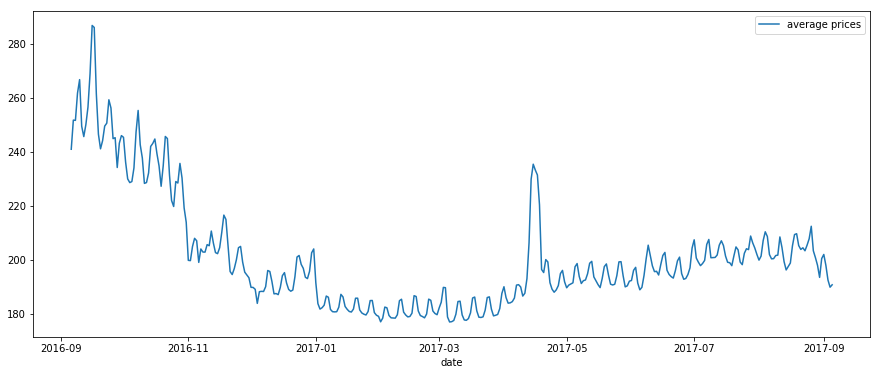

In [66]:
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=average_price_bs)

In [20]:
# check general price distribution
bs_calendar_open.describe()

,listing_id,price
count,6.430370e+05,643037.000000
mean,7.699288e+06,198.438909
std,4.766178e+06,180.142913
min,3.353000e+03,11.000000
25%,3.616081e+06,85.000000
50%,7.789055e+06,150.000000
75%,1.228796e+07,255.000000
max,1.493346e+07,7163.000000


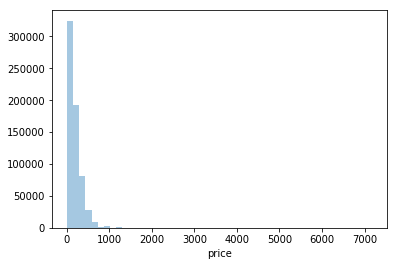

In [21]:
sns.distplot(bs_calendar_open.price, kde=False)
# price large than 1000 is pretty rare

In [22]:
# average avaliablity for each house
avaliable_days_bs = bs_calendar.groupby('listing_id').apply(lambda x: x.notnull().mean())[['price']]

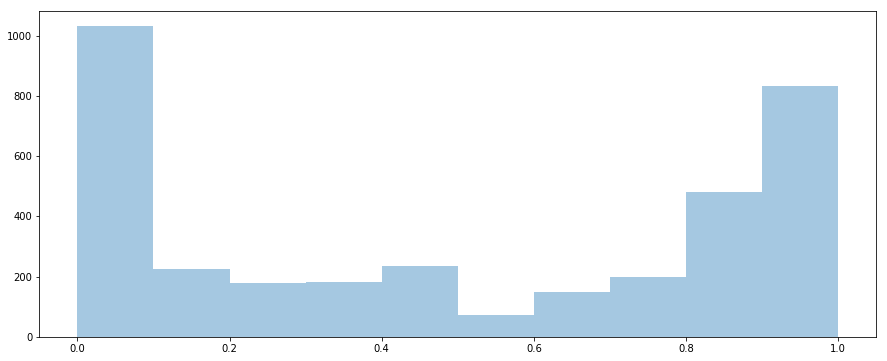

In [67]:
#avaliable_days_bs.head()
f, ax = plt.subplots(figsize=(15, 6))
sns.distplot(avaliable_days_bs, kde=False)
# a large portion of houses are available for a small portion of days

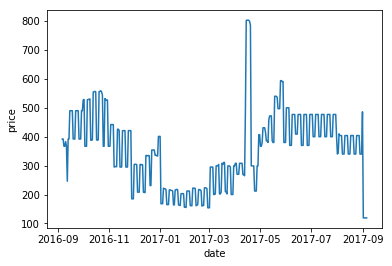

In [24]:
# visualize price change pattern for a particular listing 
list_price_eg = bs_calendar_open[bs_calendar_open.listing_id == 14421304]
sns.lineplot(x="date",y="price", data=list_price_eg)

# House number increase pattern

In [25]:
# what's the trend of airbnb business growth?
# change date type 'str' to 'datetime'
to_datetime = lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d')
bs_listing.host_since = bs_listing.host_since.apply(to_datetime)

In [26]:
# host since house count
bs_cumhost = bs_listing.groupby('host_since').count()[['id']]
# change column name
bs_cumhost = bs_cumhost.rename({"id":"house_num"},axis='columns')

In [27]:
bs_cumhost['cum_house_num'] = bs_cumhost.house_num.cumsum()
bs_cumhost.head()

,house_num,cum_house_num
host_since,,
2008-11-11,2,2
2008-12-03,1,3
2009-02-16,1,4
2009-02-17,1,5
2009-02-19,6,11


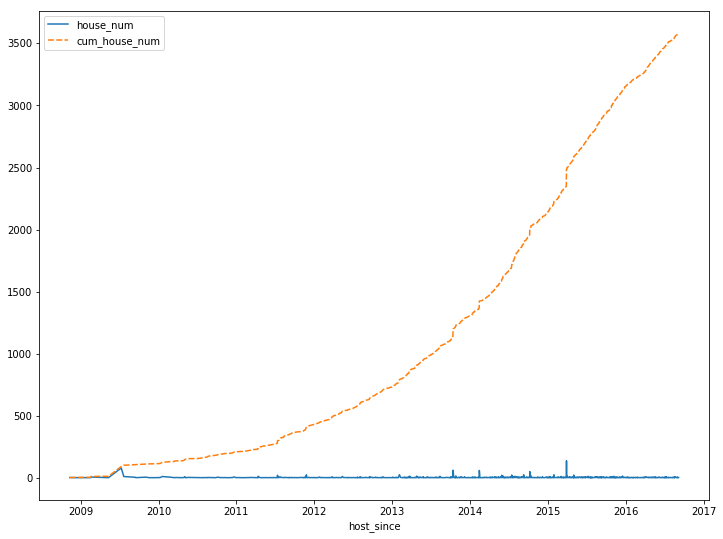

In [64]:
f, ax = plt.subplots(figsize=(12, 9))
sns.lineplot(data=bs_cumhost)
# it grows exponentially

In [29]:
bs_listing['year_month'] = bs_listing.host_since.dt.to_period('M')

In [30]:
bs_host_neigh = bs_listing.groupby(['year_month','neighbourhood_cleansed']).count()[['id']]
bs_host_neigh.reset_index(inplace=True)
bs_host_neigh.head(10)

,year_month,neighbourhood_cleansed,id
0,2008-11,Allston,2
1,2008-12,East Boston,1
2,2009-02,Jamaica Plain,1
3,2009-02,Roxbury,7
4,2009-05,Roslindale,1
5,2009-07,Back Bay,28
6,2009-07,Beacon Hill,6
7,2009-07,Chinatown,4
8,2009-07,Downtown,17
9,2009-07,Fenway,12


In [31]:
# calculate cumulative listing
bs_host_neigh = bs_host_neigh.sort_values(by=['neighbourhood_cleansed','year_month'],ascending=[True, True])
bs_host_neigh['cumnum'] = bs_host_neigh.groupby(by=['neighbourhood_cleansed'])['id'].apply(lambda x: x.cumsum())
bs_host_neigh.head()

,year_month,neighbourhood_cleansed,id,cumnum
0,2008-11,Allston,2,2
14,2009-09,Allston,4,6
47,2010-10,Allston,2,8
64,2011-02,Allston,1,9
74,2011-04,Allston,2,11


In [32]:
# drop unneeded column
bs_host_neigh.drop(['id'],inplace=True,axis=1)

In [33]:
# long to wide and fill na
bs_host_neigh_wide = bs_host_neigh.pivot('year_month', 'neighbourhood_cleansed')
bs_host_neigh_wide = bs_host_neigh_wide.fillna(method='ffill')
bs_host_neigh_wide = bs_host_neigh_wide.fillna(0)

In [34]:
# rename columns
bs_host_neigh_wide.rename(columns=lambda x: 'col_'+x, inplace=True)
# reset index
bs_host_neigh_wide.reset_index(inplace=True)
bs_host_neigh_wide.head()

year_month  col_cumnum                               \
neighbourhood_cleansed            col_Allston col_Back Bay col_Bay Village   
0                         2008-11         2.0          0.0             0.0   
1                         2008-12         2.0          0.0             0.0   
2                         2009-02         2.0          0.0             0.0   
3                         2009-05         2.0          0.0             0.0   
4                         2009-07         2.0         28.0             0.0   

                                                                     \
neighbourhood_cleansed col_Beacon Hill col_Brighton col_Charlestown   
0                                  0.0          0.0             0.0   
1                                  0.0          0.0             0.0   
2                                  0.0          0.0             0.0   
3                                  0.0          0.0             0.0   
4                                  6.0          0.0             0.0   

                                                                  \
neighbourhood_cleansed col_Chinatown col_Dorchester col_Downtown   
0                                0.0            0.0          0.0   
1                                0.0            0.0          0.0   
2                                0.0            0.0          0.0   
3                                0.0            0.0          0.0   
4                                4.0            0.0         17.0   

                             ...                                       \
neighbourhood_cleansed       ...        col_Mattapan col_Mission Hill   
0                            ...                 0.0              0.0   
1                            ...                 0.0              0.0   
2                            ...                 0.0              0.0   
3                            ...                 0.0              0.0   
4                            ...                 0.0              6.0   

                                                                 \
neighbourhood_cleansed col_North End col_Roslindale col_Roxbury   
0                                0.0            0.0         0.0   
1                                0.0            0.0         0.0   
2                                0.0            0.0         7.0   
3                                0.0            1.0         7.0   
4                                0.0            1.0         7.0   

                                                                     \
neighbourhood_cleansed col_South Boston col_South Boston Waterfront   
0                                   0.0                         0.0   
1                                   0.0                         0.0   
2                                   0.0                         0.0   
3                                   0.0                         0.0   
4                                   0.0                         1.0   

                                                                    
neighbourhood_cleansed col_South End col_West End col_West Roxbury  
0                                0.0          0.0              0.0  
1                                0.0          0.0              0.0  
2                                0.0          0.0              0.0  
3                                0.0          0.0              0.0  
4                                8.0          7.0              0.0  

[5 rows x 26 columns]

In [35]:
# remove first row
bs_host_neigh_wide_clean = bs_host_neigh_wide['col_cumnum']
bs_host_neigh_wide_clean['year_month'] = bs_host_neigh_wide['year_month']
bs_host_neigh_wide_clean.tail()

neighbourhood_cleansed,col_Allston,col_Back Bay,col_Bay Village,col_Beacon Hill,col_Brighton,col_Charlestown,col_Chinatown,col_Dorchester,col_Downtown,col_East Boston,...,col_Mission Hill,col_North End,col_Roslindale,col_Roxbury,col_South Boston,col_South Boston Waterfront,col_South End,col_West End,col_West Roxbury,year_month
83,246.0,292.0,23.0,184.0,164.0,105.0,66.0,254.0,164.0,140.0,...,116.0,137.0,55.0,141.0,170.0,80.0,314.0,48.0,42.0,2016-05
84,255.0,294.0,23.0,187.0,170.0,107.0,66.0,259.0,164.0,143.0,...,118.0,141.0,55.0,143.0,170.0,81.0,320.0,48.0,43.0,2016-06
85,257.0,299.0,23.0,191.0,177.0,108.0,69.0,263.0,169.0,147.0,...,122.0,143.0,56.0,144.0,171.0,82.0,322.0,48.0,44.0,2016-07
86,260.0,302.0,24.0,191.0,183.0,110.0,70.0,268.0,171.0,149.0,...,124.0,143.0,56.0,144.0,174.0,83.0,325.0,49.0,46.0,2016-08
87,260.0,302.0,24.0,194.0,185.0,111.0,71.0,269.0,172.0,150.0,...,124.0,143.0,56.0,144.0,174.0,83.0,326.0,49.0,46.0,2016-09


In [59]:
# wide to long
bs_host_neigh_wide_long = bs_host_neigh_wide_clean.melt('year_month', var_name='cols',  value_name='vals')
bs_host_neigh_wide_long = bs_host_neigh_wide_long.rename(columns={"cols": "neighbourhood", "vals": "cum_listings"})
bs_host_neigh_wide_long.tail()

,year_month,neighbourhood,cum_listings
2195,2016-05,col_West Roxbury,42.0
2196,2016-06,col_West Roxbury,43.0
2197,2016-07,col_West Roxbury,44.0
2198,2016-08,col_West Roxbury,46.0
2199,2016-09,col_West Roxbury,46.0


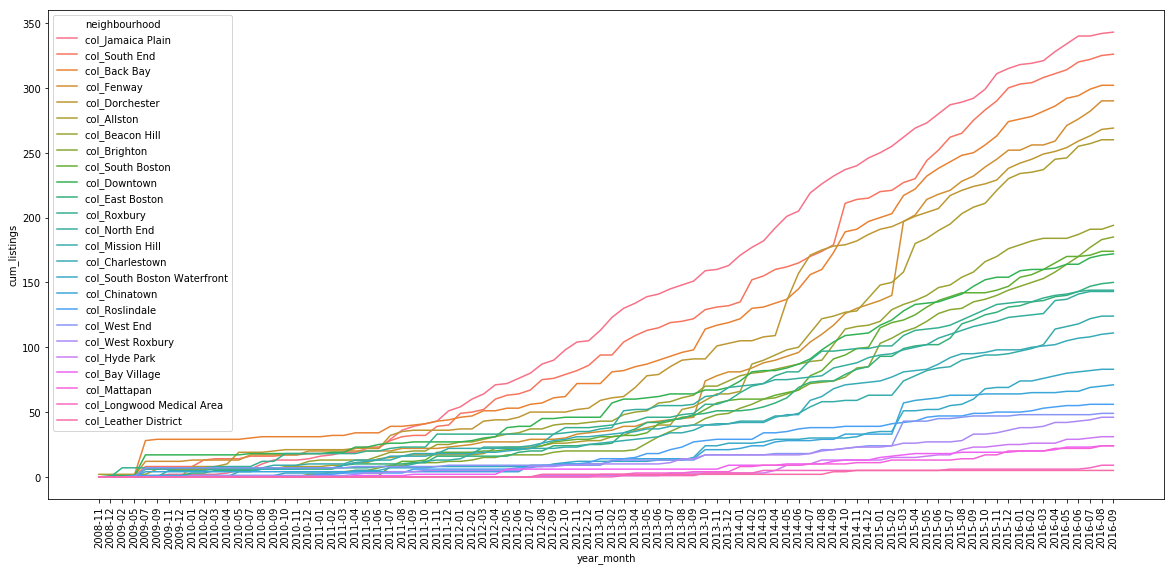

In [60]:
f, ax = plt.subplots(figsize=(20, 9))
bs_host_neigh_wide_long.year_month = bs_host_neigh_wide_long.year_month.apply(lambda x:str(x))
last_date = bs_host_neigh_wide_long[bs_host_neigh_wide_long.year_month==max(bs_host_neigh_wide_long.year_month)]
hue_order = last_date.sort_values(by=['cum_listings'],ascending=False)['neighbourhood']
g=sns.lineplot(x='year_month',y='cum_listings',hue='neighbourhood', hue_order =hue_order ,data=bs_host_neigh_wide_long)
g=g.set_xticklabels(bs_host_neigh_wide_long.year_month.unique(),rotation=90)

# Ratings and Prices

In [42]:
# select price and ratings and dropna
bs_price_rate = bs_listing[["id","price","review_scores_rating","number_of_reviews"]].dropna()

In [43]:
bs_price_rate.price = bs_price_rate.price.apply(remove_dollar)

In [44]:
bs_price_rate.head()

,id,price,review_scores_rating,number_of_reviews
1,3075044,65.0,94.0,36
2,6976,65.0,98.0,41
3,1436513,75.0,100.0,1
4,7651065,79.0,99.0,29
5,12386020,75.0,100.0,8


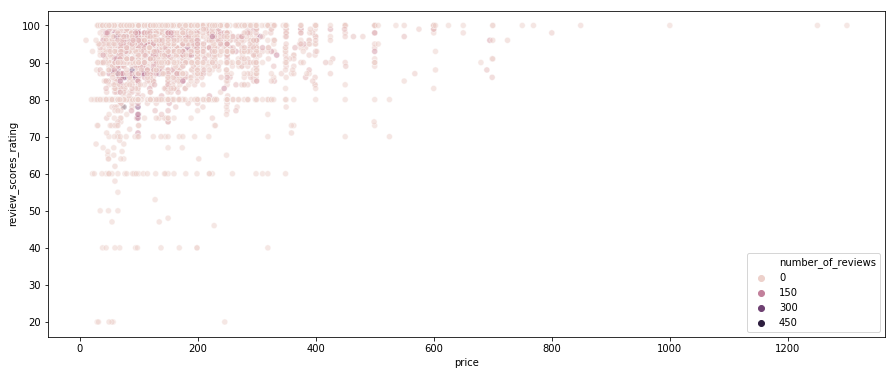

In [68]:
f, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='price',y='review_scores_rating',hue='number_of_reviews',alpha=0.5,data=bs_price_rate)
# low ratings are associate with lower prices.
# however high rating dose not mean high price

In [46]:
bs_price_rate.describe()

,id,price,review_scores_rating,number_of_reviews
count,2.772000e+03,2772.000000,2772.000000,2772.000000
mean,7.627088e+06,166.684343,91.916667,24.606782
std,4.386274e+06,112.972898,9.531686,38.730995
min,3.353000e+03,11.000000,20.000000,1.000000
25%,4.078974e+06,85.000000,89.000000,3.000000
50%,7.713772e+06,145.000000,94.000000,10.000000
75%,1.175728e+07,215.000000,98.250000,29.000000
max,1.484378e+07,1300.000000,100.000000,404.000000


In [82]:
# find the listing with the highest number of reviews
max_id = bs_price_rate[bs_price_rate.number_of_reviews == max(bs_price_rate.number_of_reviews)]
max_id

,id,price,review_scores_rating,number_of_reviews
414,66288,75.0,78.0,404


In [76]:
# info of this listing
bs_listing[bs_listing.id== 66288].T

,414
id,66288
listing_url,https://www.airbnb.com/rooms/66288
scrape_id,20160906204935
last_scraped,2016-09-07
name,Architects Live-in Studio in Boston
summary,NaN
space,"Apartment now has permanent, hi-speed cable in..."
description,"Apartment now has permanent, hi-speed cable in..."
experiences_offered,none
neighborhood_overview,NaN


In [81]:
bs_calendar[bs_calendar.listing_id==66288 ].count()

listing_id    365
date          365
available     365
price         281
dtype: int64

# Price Influence Factors

In [47]:
# keep listings with not null prices
bs_listing_price = bs_listing[bs_listing.price.notnull()]
bs_listing_price.price = bs_listing_price.price.apply(remove_dollar)

In [48]:
# price and neighborhood
price_area = bs_listing_price.groupby('neighbourhood_cleansed').mean()[['price']]
price_area.reset_index(inplace=True)

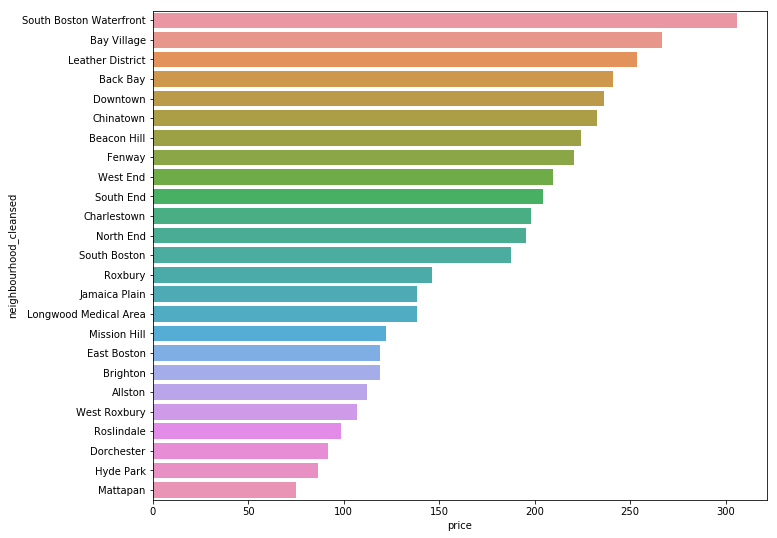

In [83]:
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(y='neighbourhood_cleansed',x='price',data=price_area.sort_values(by='price', ascending=False))

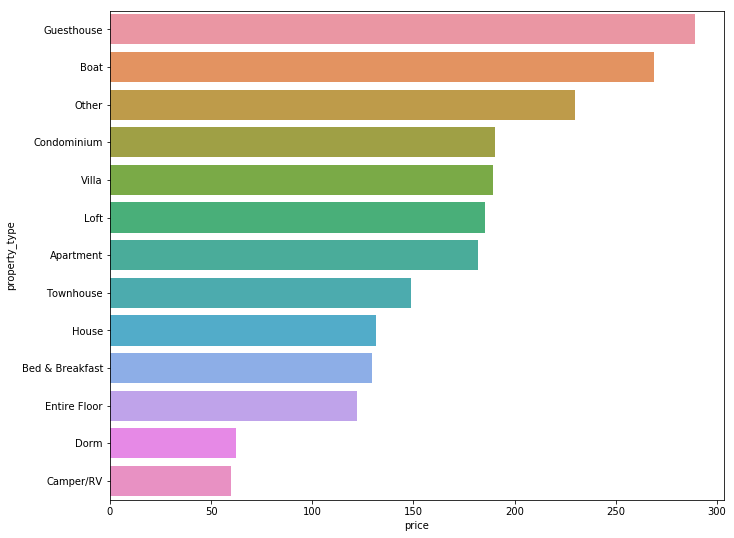

In [84]:
# price and property type
price_property_type = bs_listing_price.groupby('property_type').mean()[['price']]
price_property_type.reset_index(inplace=True)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(y='property_type',x='price',data=price_property_type.sort_values(by='price', ascending=False))

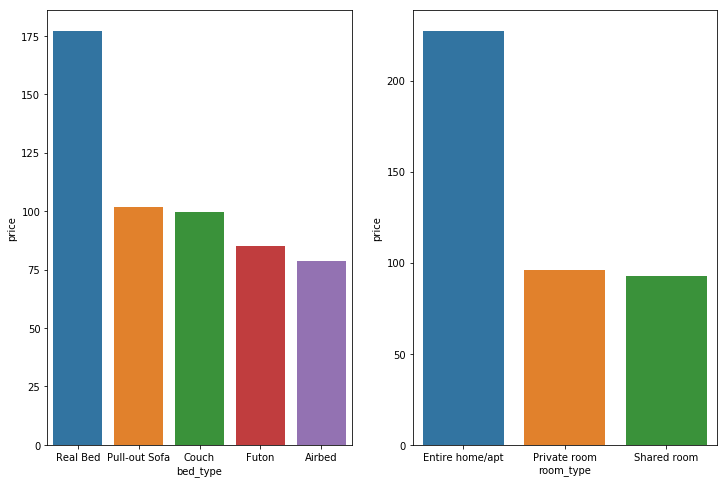

In [89]:
# price and bed_type
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
price_bed_type = bs_listing_price.groupby('bed_type').mean()[['price']]
price_bed_type.reset_index(inplace=True)
sns.barplot(x='bed_type',y='price',data=price_bed_type.sort_values(by='price', ascending=False),ax=ax1)
# price and bed_type
price_room_type = bs_listing_price.groupby('room_type').mean()[['price']]
price_room_type.reset_index(inplace=True)
sns.barplot(x='room_type',y='price',data=price_room_type.sort_values(by='price', ascending=False),ax=ax2)

In [54]:
# see how numerical values correlate with price
bs_listing_price_num = bs_listing_price.select_dtypes(include=['float64','int'])

In [55]:
bs_listing_price_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 0 to 3584
Data columns (total 34 columns):
id                                3585 non-null int64
scrape_id                         3585 non-null int64
host_id                           3585 non-null int64
host_listings_count               3585 non-null int64
host_total_listings_count         3585 non-null int64
neighbourhood_group_cleansed      0 non-null float64
latitude                          3585 non-null float64
longitude                         3585 non-null float64
accommodates                      3585 non-null int64
bathrooms                         3571 non-null float64
bedrooms                          3575 non-null float64
beds                              3576 non-null float64
square_feet                       56 non-null float64
price                             3585 non-null float64
guests_included                   3585 non-null int64
minimum_nights                    3585 non-null int64
maximum_nights    

In [56]:
# drop irrelevent colunms
bs_listing_price_num = bs_listing_price_num.drop(['id','scrape_id','host_id','latitude','longitude','jurisdiction_names',
                          'neighbourhood_group_cleansed','license','has_availability','neighbourhood_group_cleansed'], axis=1)

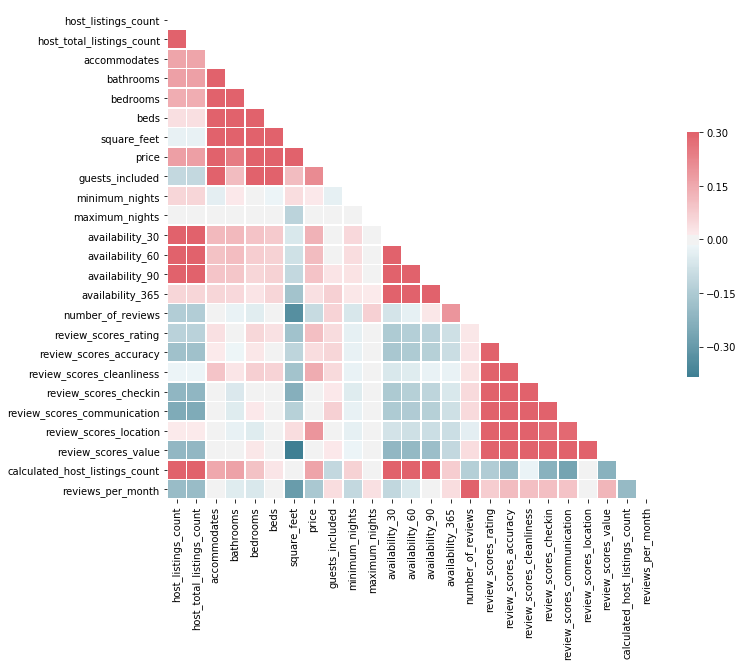

In [57]:
corr = bs_listing_price_num.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})